<a href="https://colab.research.google.com/github/Kavyakulukuri/FMML-LAB-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-15 07:19:25--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.126, 18.160.200.71, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   170MB/s    in 0.3s    

2024-05-15 07:19:25 (170 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


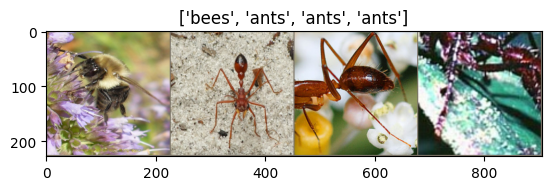

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.6MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5852 Acc: 0.6844

Epoch 1/4
----------
Loss: 0.5965 Acc: 0.7500

Epoch 2/4
----------
Loss: 0.4668 Acc: 0.8197

Epoch 3/4
----------
Loss: 0.4744 Acc: 0.8074

Epoch 4/4
----------
Loss: 0.5711 Acc: 0.7787



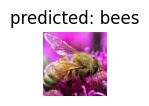

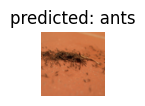

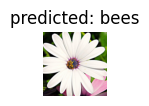

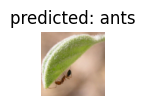

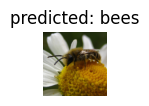

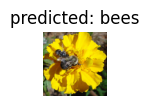

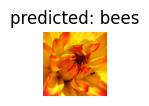

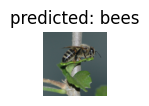

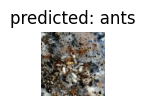

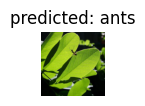

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?
Data augmentation techniques, such as resizing, cropping, flipping, rotating, and adding noise to training data, are significant in machine learning and deep learning for several reasons:

Increased Dataset Size: Augmentations effectively increase the diversity of your training dataset without collecting new data. This is crucial, especially when the available dataset is limited, preventing overfitting and enhancing generalization.

Robustness to Variations: By exposing the model to variations of the same image, such as different scales, angles, and lighting conditions, it learns to be more robust and invariant to such changes during inference, improving its performance on real-world data.

Regularization: Data augmentation acts as a form of regularization, preventing the model from memorizing the training set and instead learning more generalizable features. This helps in reducing overfitting and improving the model's ability to generalize to unseen data.

Improved Feature Learning: Augmentation encourages the model to learn features that are invariant to transformations present in the augmented data. For example, a model trained on images with various rotations will learn to recognize objects regardless of their orientation.

Reduced Bias: Augmentation can help reduce biases present in the original dataset. For instance, if the training data contains images predominantly of certain classes or from particular perspectives, augmentations can balance this bias by generating variations that are underrepresented.

Domain Adaptation: In transfer learning scenarios, where pre-trained models are fine-tuned on new tasks or domains, data augmentation helps adapt the model to the new data distribution by generating diverse examples within the target domain.

Cost and Time Efficiency: Augmentation is a cost-effective and time-efficient way to enhance the dataset compared to collecting and labeling new data, especially in domains where acquiring new samples is expensive or impractical.

Overall, data augmentation is a powerful technique in machine learning and deep learning pipelines, contributing to better model performance, generalization, and robustness to real-world variations.





2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)
If you train a ResNet model from scratch (i.e., without using pre-trained weights), it may require significantly more data and computational resources compared to using pre-trained weights. The performance of the model trained from scratch could be affected in several ways:

1. **Training Time**: Training a deep neural network like ResNet from scratch requires more time and computational resources compared to fine-tuning a pre-trained model. The network has to learn features from raw pixel values, which is computationally expensive.

2. **Data Efficiency**: Without pre-trained weights, the model needs to learn all features from scratch, which might require a larger dataset to achieve comparable performance to a pre-trained model. Training from scratch might be prone to overfitting, especially with smaller datasets.

3. **Generalization**: Pre-trained models have already learned generic features from large-scale datasets, which can help in generalizing well to new tasks or domains. Without pre-training, the model might not capture as rich and generalized features, leading to lower performance on unseen data.

4. **Convergence**: Training from scratch might require careful hyperparameter tuning and longer training time to achieve convergence compared to fine-tuning a pre-trained model, which already has learned useful representations.

5. **Resource Requirements**: Training from scratch might require access to powerful computational resources like GPUs or TPUs, as well as large amounts of training data, to achieve good performance.

In summary, while training a ResNet model from scratch is possible, it might not achieve the same level of performance or efficiency as using pre-trained weights, especially in scenarios with limited computational resources or data.

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?
Using a pre-trained ResNet model on a dataset significantly different from the ants vs. bees dataset can still provide a good starting point for transfer learning, but the performance may not be optimal compared to using a pre-trained model on a more similar dataset. Here are some considerations:

Domain Differences: If the pre-trained ResNet model was trained on a dataset that differs significantly from the ants vs. bees dataset in terms of content, style, or distribution, the learned features may not directly transfer to the new task. For example, if the pre-trained model was trained on a dataset of natural scenes, it may not capture specific features relevant to distinguishing between ants and bees.

Feature Reusability: Despite domain differences, lower-level features learned by the pre-trained model (such as edges, textures, and basic shapes) might still be useful for the new task. These features are often transferable across domains and can provide a good starting point for fine-tuning on the ants vs. bees dataset.

Fine-Tuning: Fine-tuning the pre-trained model on the ants vs. bees dataset allows the model to adapt its higher-level representations to better suit the new task. Even if the pre-trained model's features are not directly applicable, fine-tuning can help the model learn task-specific features while leveraging the general knowledge gained from the pre-training.

Amount of Transfer Learning: The effectiveness of transfer learning depends on the similarity between the pre-training dataset and the target dataset, as well as the amount of transferable knowledge in the pre-trained model. If the domain shift between the datasets is too large or the pre-trained model's features are not relevant to the new task, the performance gain from transfer learning may be limited.

In conclusion, while using a pre-trained ResNet model on a significantly different dataset may not yield optimal performance initially, it can still provide valuable insights and accelerate the learning process through transfer learning and fine-tuning. The extent of performance improvement will depend on the degree of domain similarity and the model's capacity to adapt to the new task.



